numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba 

Optimal Capacitor Placements (in MVAR):
Bus 4: 0.289 MVAR
Bus 5: 0.297 MVAR
Bus 6: 0.282 MVAR
Bus 7: 0.298 MVAR
Bus 8: 0.289 MVAR
Total Power Loss: 4.9477 MW


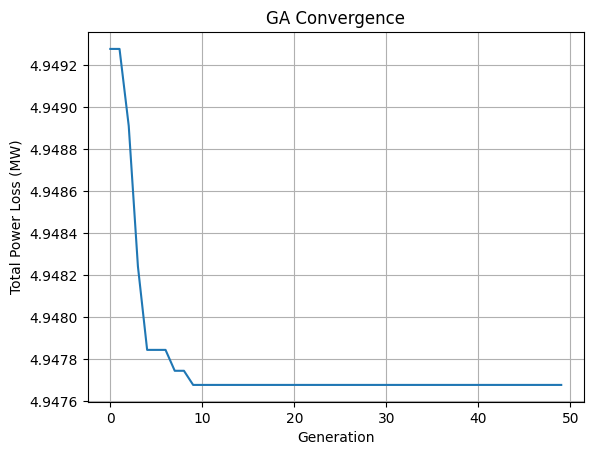

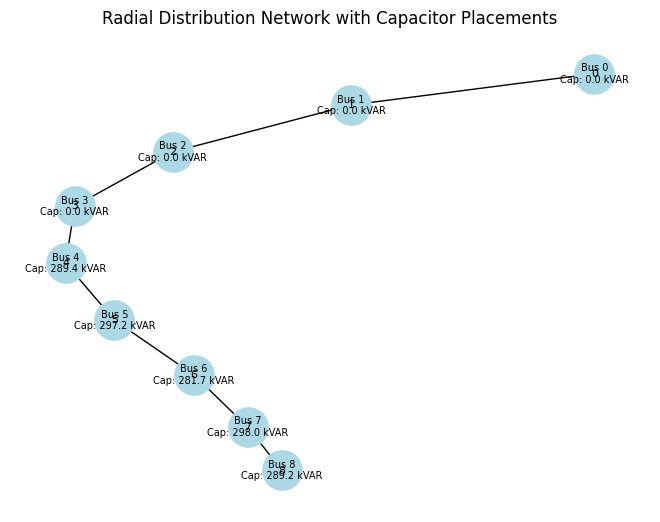

In [1]:
import pandapower as pp
import pandapower.networks as pn
import numpy as np
import random
import matplotlib.pyplot as plt
import networkx as nx
import os
import warnings





os.environ['NUMBA_DISABLE_JIT'] = '1'
warnings.simplefilter(action='ignore', category=FutureWarning)

# Load IEEE 9-bus system
net = pn.case9()


candidate_buses = [4, 5, 6, 7, 8]

# GA parameters
POP_SIZE = 20
NUM_GENERATIONS = 50
MUTATION_RATE = 0.1
CAP_MIN = 0  # in MVAR
CAP_MAX = 0.3  # in MVAR

def create_individual():
    return [random.uniform(CAP_MIN, CAP_MAX) for _ in candidate_buses]

def apply_caps(net, caps):
    net.shunt.drop(net.shunt.index, inplace=True)
    for bus, q_mvar in zip(candidate_buses, caps):
        if q_mvar > 0:
            pp.create_shunt(net, bus=bus, q_mvar=-q_mvar, p_mw=0.0)

def fitness(individual):
    apply_caps(net, individual)
    try:
        pp.runpp(net)
        loss = net.res_line.pl_mw.sum()
        return loss
    except:
        # If power flow doesn't converge, assign a high penalty
        return 1e6

# Initialize population
population = [create_individual() for _ in range(POP_SIZE)]
best_scores = []

for gen in range(NUM_GENERATIONS):
    scores = [fitness(ind) for ind in population]
    best_score = min(scores)
    best_scores.append(best_score)
    sorted_population = [ind for _, ind in sorted(zip(scores, population))]
    population = sorted_population[:POP_SIZE // 2]
    children = []
    while len(children) < POP_SIZE // 2:
        parent1, parent2 = random.sample(population, 2)
        crossover_point = random.randint(1, len(candidate_buses) - 1)
        child = parent1[:crossover_point] + parent2[crossover_point:]
        # Mutation
        if random.random() < MUTATION_RATE:
            mutate_idx = random.randint(0, len(candidate_buses) - 1)
            child[mutate_idx] = random.uniform(CAP_MIN, CAP_MAX)
        children.append(child)
    population += children

best_individual = population[0]
apply_caps(net, best_individual)
pp.runpp(net)
print("Optimal Capacitor Placements (in MVAR):")
for bus, q in zip(candidate_buses, best_individual):
    print(f"Bus {bus}: {q:.3f} MVAR")
print(f"Total Power Loss: {net.res_line.pl_mw.sum():.4f} MW")

# Plot
plt.plot(best_scores)
plt.title("GA Convergence")
plt.xlabel("Generation")
plt.ylabel("Total Power Loss (MW)")
plt.grid(True)
plt.show()
capacitor_mapping = {bus: cap for bus, cap in zip(candidate_buses, best_individual)}
#Netwrok graph
G = nx.Graph()
for i in range(len(net.bus)):
    cap_value = capacitor_mapping.get(i, 0)
    G.add_node(i, label=f"Bus {i}\nCap: {cap_value * 1000:.1f} kVAR")
for i in range(len(net.bus) - 1):
    G.add_edge(i, i + 1)

pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=800, font_size=8)
labels = nx.get_node_attributes(G, 'label')
nx.draw_networkx_labels(G, pos, labels=labels, font_size=7)
plt.title("Radial Distribution Network with Capacitor Placements")
plt.show()
